# Auxilliary Tutorial 5: Principal Component Analysis (PCA)
*This tutorial was prepared by Manuel Razo-Mejia and was generated from an Jupyter notebook.  You can download the notebook [here](r5_pca.ipynb).*


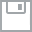
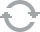
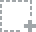
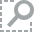
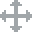
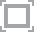
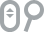
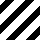
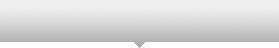
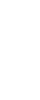
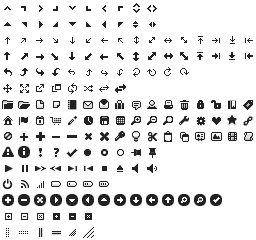
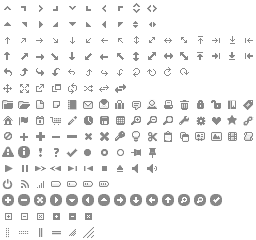
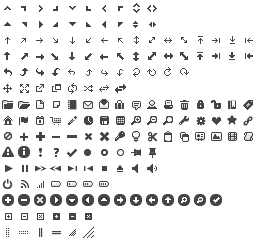
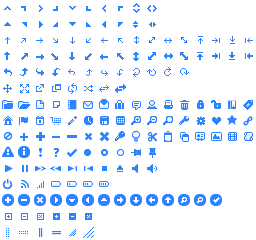
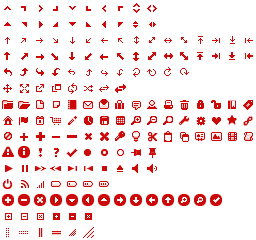
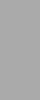
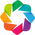
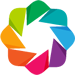

In [1]:
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.stats as st

# Import pyplot for plotting
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d

# Seaborn, useful for graphics
import seaborn as sns

# Package to perform PCA
import sklearn.datasets
import sklearn.decomposition

# Utilities for our class
import bebi103

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Import Bokeh modules for interactive plotting
import bokeh.charts
import bokeh.charts.utils
import bokeh.io
import bokeh.models
import bokeh.palettes
import bokeh.plotting

# Display graphics in this notebook
bokeh.io.output_notebook()

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In this tutorial, we will learn about a technique known as **principal component analysis**, or **PCA**.

[Lior Pachter](https://math.berkeley.edu/~lpachter/) has a fantastic [blog entry](https://liorpachter.wordpress.com/2014/05/26/what-is-principal-component-analysis/) explaining the details behind PCA. There Lior gives 3 alternative definitions of what PCA is:
1. An affine subspace closest to a set of points.
2. A generalization of linear regression in which the Gaussian noise is isotropic.
3. An orthogonal projection of points onto an affine space that maximizes the retained sample variance.

Although the mathematical rigor behind each definition is extremely beautiful, it is impossible for me to give a better explanation that the one given in his blog entry. For our purposes we will be sloppy and think of PCA as a projection of high dimensional data into a lower dimension space where each dimension is formed by a linear combination of the original dimensions.

## The famous iris data set

We will use one of the most famous datasets available online. This data set, collected by Edgar Anderson and popularized by the one and only [Ronald Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher), contains the petal and sepal length and width in three different species of Iris (*Iris setosa, Iris virginica and Iris versicolor*).

To give you an idea of how popular this data set is I can tell you that it has its own [Wikipedia entry](https://en.wikipedia.org/wiki/Iris_flower_data_set), you can import it with [seaborn](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.pairplot.html?highlight=iris), [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html), or even with pandas using

    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
    df = pd.read_csv(filepath_or_buffer=url, header=None, sep=',')

For this tutorial we will import it using `scikit-learn` and transform it into a tidy data frame.

In [2]:
# Import the Iris dataset and convert it into a Pandas Data Frame
iris = sklearn.datasets.load_iris()

# Uncomment if you want to print the dataset description
# print(iris.DESCR)

# Make a DataFrame with a species column
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
df_iris['species'] = iris.target_names[iris.target]

# Takle a look
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


We can do some exploratory analysis using seaborn's `pairplot()` function to make pairwise comparisons between the measurements.

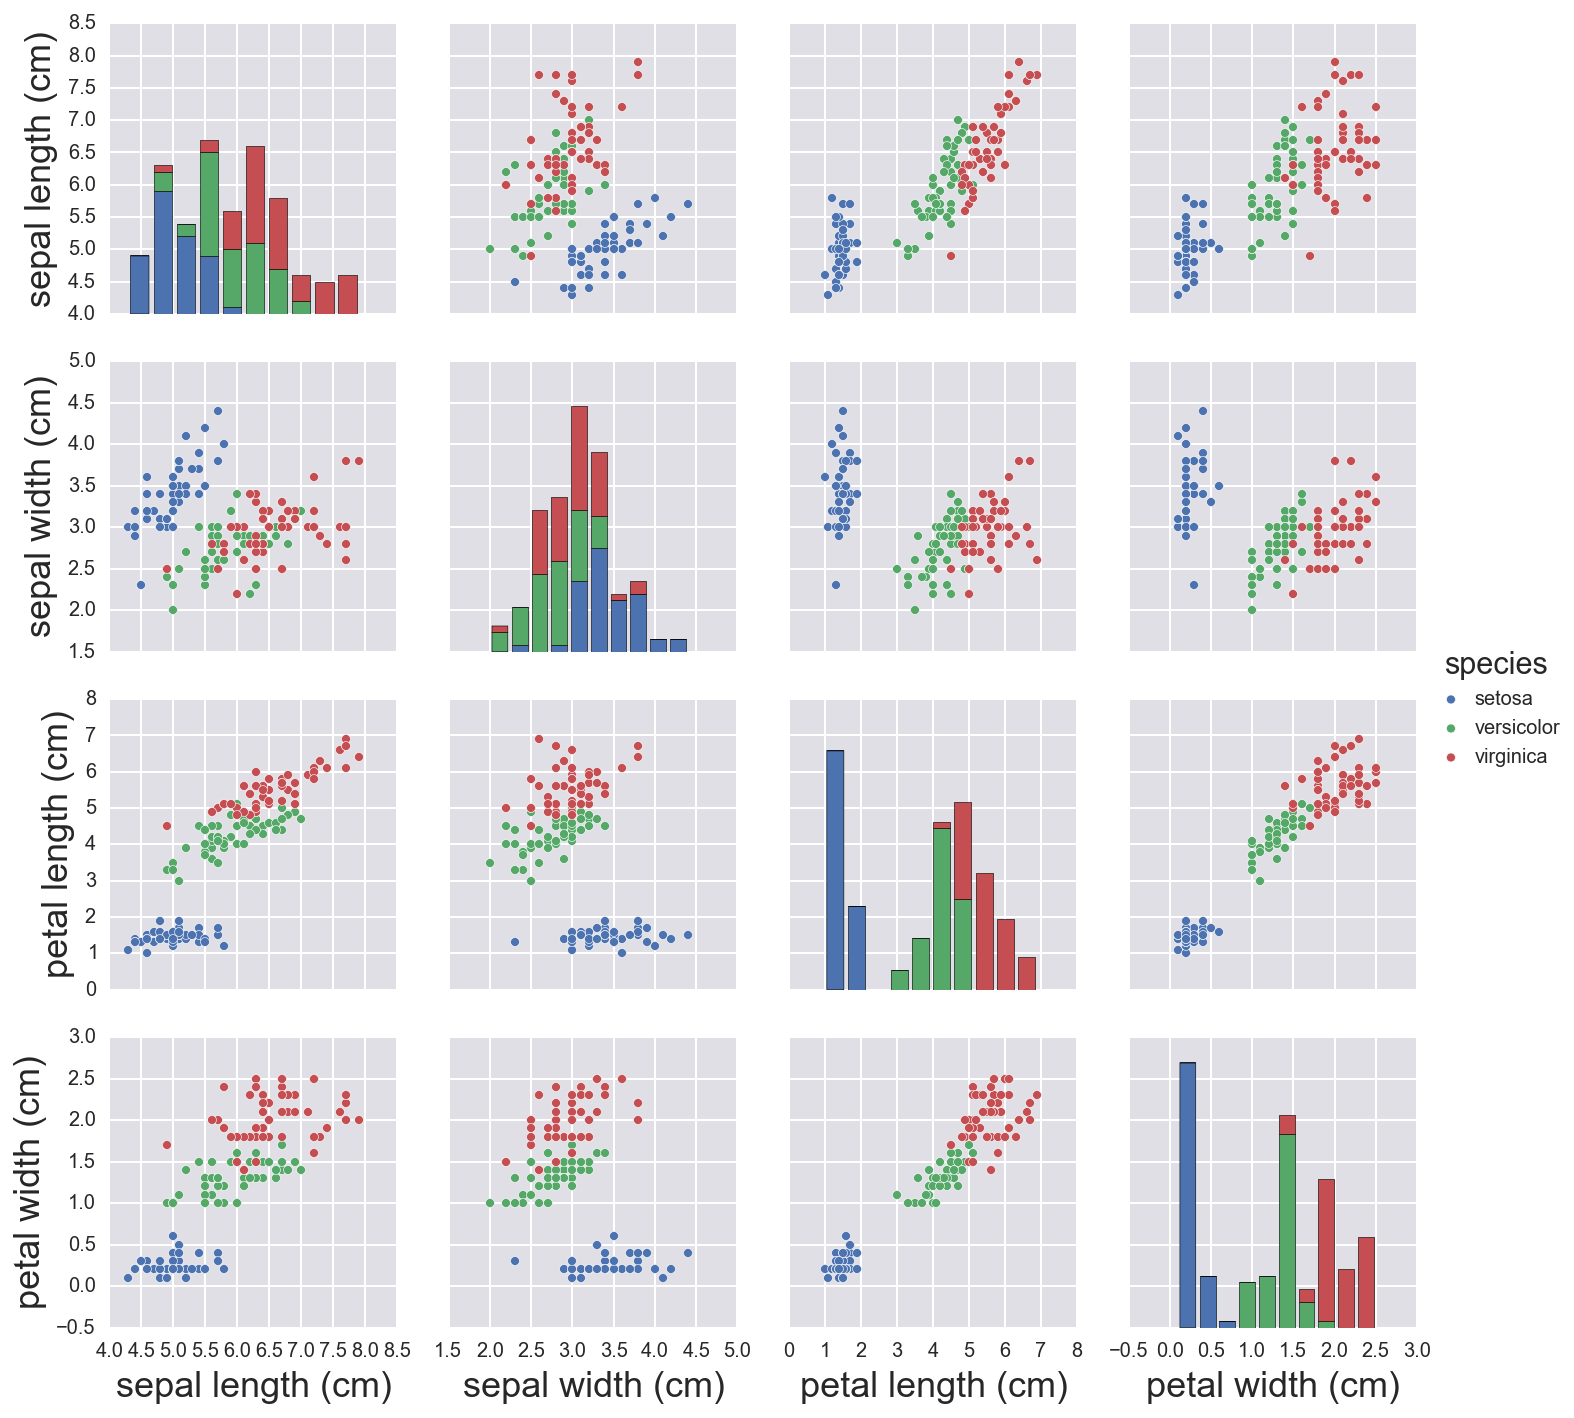

In [3]:
# Plot pairwise comparison to explore the data
_ = sns.pairplot(df_iris, hue='species')

Right away from this plot we can notice that *versicolor* and *virginica* are more similar to each other than to *setosa*.  Another thing we can notice is that there is a strong correlation between *petal length* and *petal width*. We can use this to explain the concept behind PCA. So, let's focus on these two parameters.

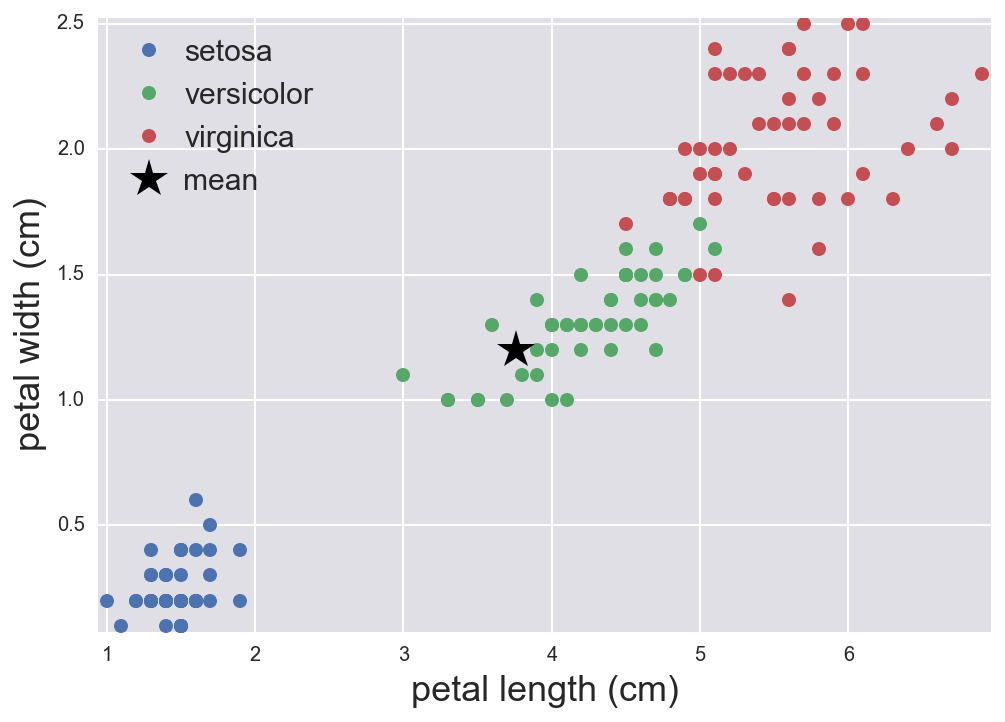

In [5]:
# Compute the mean
m = np.array([df_iris['petal length (cm)'].mean(), 
              df_iris['petal width (cm)'].mean()])

# Plot petal length vs petal width only
for key, group in df_iris.groupby(['species']):
    plt.plot(group['petal length (cm)'], group['petal width (cm)'],
               label=key, marker='o', linestyle='none')

# Add the mean value to the plot
plt.plot(m[0], m[1],
         marker='*', color='black', markersize=20,
         linestyle='none', label='mean')

plt.legend(loc=0, fontsize=15)
plt.margins(0.01)
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)');

## "Manual" PCA

To perform PCA in Python is as simple as a one-line command from `scikit-learn`. But in order to ilustrate the procedure we will compute it "*manually*" using an [eigendecomposition](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix).

**1)** First we generate a `DataFrame` centered at the mean.

In [10]:
# Substract the mean from the measurements.
df_cent = df_iris.loc[:, ['petal length (cm)', 'petal width (cm)']]
df_cent.loc[:, 'petal length (cm)'] = df_cent.loc[:, 'petal length (cm)'] \
                        - df_cent.loc[:, 'petal length (cm)'].mean()
df_cent.loc[:,'petal width (cm)'] = df_cent.loc[:, 'petal width (cm)'] \
                        - df_cent.loc[:, 'petal width (cm)'].mean()

# Take a look
df_cent.head()

,petal length (cm),petal width (cm)
0,-2.358667,-0.998667
1,-2.358667,-0.998667
2,-2.458667,-0.998667
3,-2.258667,-0.998667
4,-2.358667,-0.998667


**2)** Then we compute the covariance matrix.

In [11]:
cov_mat = np.cov(m=df_cent.transpose())
print('Covariance matrix \n%s'%cov_mat)

Covariance matrix 
[[ 3.11317942  1.29638747]
 [ 1.29638747  0.58241432]]


**3)** Finally we perform an eigenvalue decomposition of the covariance matrix.

We won't cover the math behind this procedure. It is enough to say that the *principal component* directions are given by the eigenvectors of the matrix and the magnitude of the components are given by the eigenvalues.

Most of the available algorithms to do PCA use [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) instead for computational efficiency. But regardless of the algorithm the objective is still the same: compute the eigenvectors and eigenvalues from the covariance matrix.

In [14]:
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors\n', eig_vecs)
print('\nEigenvalues\n', eig_vals)

Eigenvectors
 [[ 0.92154695 -0.38826694]
 [ 0.38826694  0.92154695]]

Eigenvalues
 [ 3.65937449  0.03621925]


We can plot these eigenvectors on top of our scatter plot to get some intuition of what do they mean

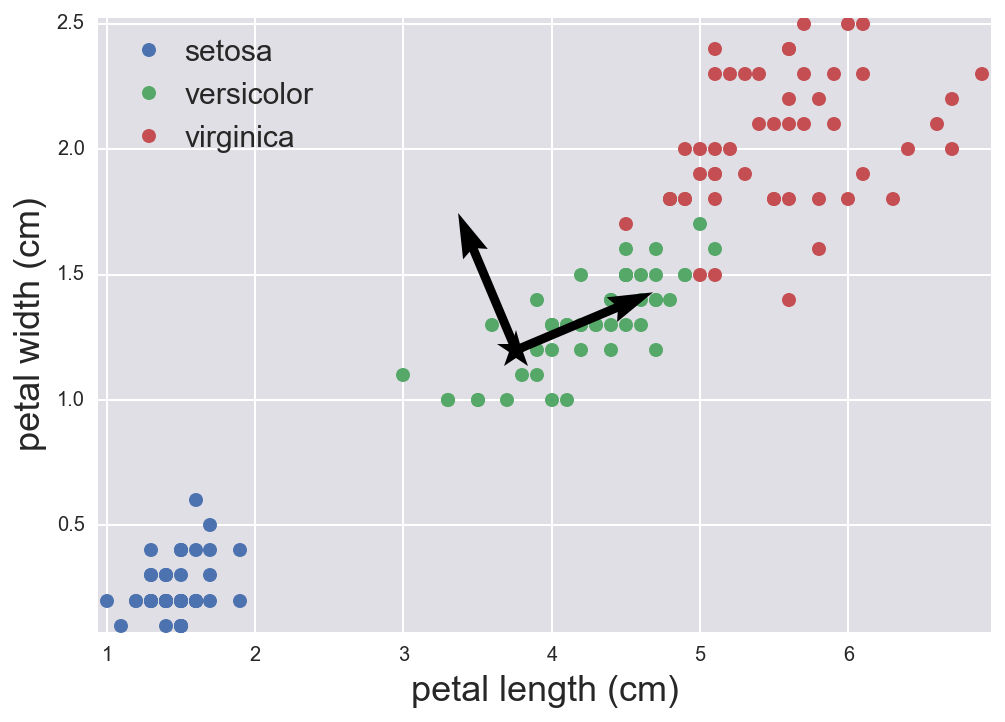

In [15]:
# Plot Petal length vs petal width only
for key, group in df_iris.groupby(['species']):
    plt.plot(group['petal length (cm)'], group['petal width (cm)'],
               label=key, marker='o', linestyle='none')

# Add the mean value to the plot
plt.plot(m[0], m[1], marker='*', color='black', markersize=20)

# Add arrows showing the eigenvectors
plt.quiver([m[0]]*2, [m[1]]*2, eig_vecs[:,1], eig_vecs[:,0], zorder=11, 
           width=0.01, scale=6)
    
# Tidy up plot
plt.legend(loc=0, fontsize=15)
plt.margins(0.01)
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')

As explained in [this incredibly useful blog](http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html#Preparing-the-Iris-Dataset) by [Sebastian Raschka](http://sebastianraschka.com/index.html) that actually uses the same data set:

>*The eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude. In other words, the eigenvalues explain the variance of the data along the new feature axes*.

We chose this pair of measurements originally because there was a clear correlation between them. This is indeed confirmed by the magnitude of the *eigenvalues* where one of them is two orders of magnitude larger than the other.

Lior's blog explains with exquisite detail how we can think of PCA as *an orthogonal projection of points onto an affine space that maximizes the retained sample variance*.
What this is saying is that when we project our high dimensional data into a lower dimension space, PCA does it such that *the **sample variance** of the projections of the observed points onto this subspace is **maximized***.

In other words, if we sort the principal components in decreasing order according to their corresponding eigenvalues the components with the largest eigenvalues explain more of the variability in the data.
This can be precisely computed as the *explained variance percent*. This explained variance tells us how much information (variance) can be attributed to each of the principal components.

So we can easily compute how much variability is explained by each of the two principal components.

In [19]:
# Compute how much variance is explained by each principal component
print("""
PCA 1: {0:.2f}% of the variance
PCA 2:  {1:.2f}% of the variance
""".format(*tuple(eig_vals / eig_vals.sum() * 100)))


PCA 1: 99.02% of the variance
PCA 2:  0.98% of the variance



From this we can see from this that if we were to project these 2D data into a 1D space we would be able to explain almost all the variability within the data.

To actually project our data into this subspace we have to multiply our data by the so-called projection matrix.
But don't get tangled with the names; if we want to project our data into a $k$-dimensional space, this matrix has columns comprized of the top *k* eigenvectors.  Nothing fancy about this.

Since in this simple example we are projecting into a 1D space we just have to multiply our data by the eigenvector with the largest corresponding eigenvalue.

In [20]:
# Project data to our 1D space
df_1D = pd.DataFrame(df_iris[['petal length (cm)',\
                              'petal width (cm)']].dot(eig_vecs[:,0]),
                    columns=['projection'])

# Add back the species column
df_1D['species'] = df_iris['species']
df_1D.head()

,projection,species
0,1.367819,setosa
1,1.367819,setosa
2,1.275664,setosa
3,1.459974,setosa
4,1.367819,setosa


Now we can plot our data in 1D only while maintaining ≈98% percent of the variability in the data!

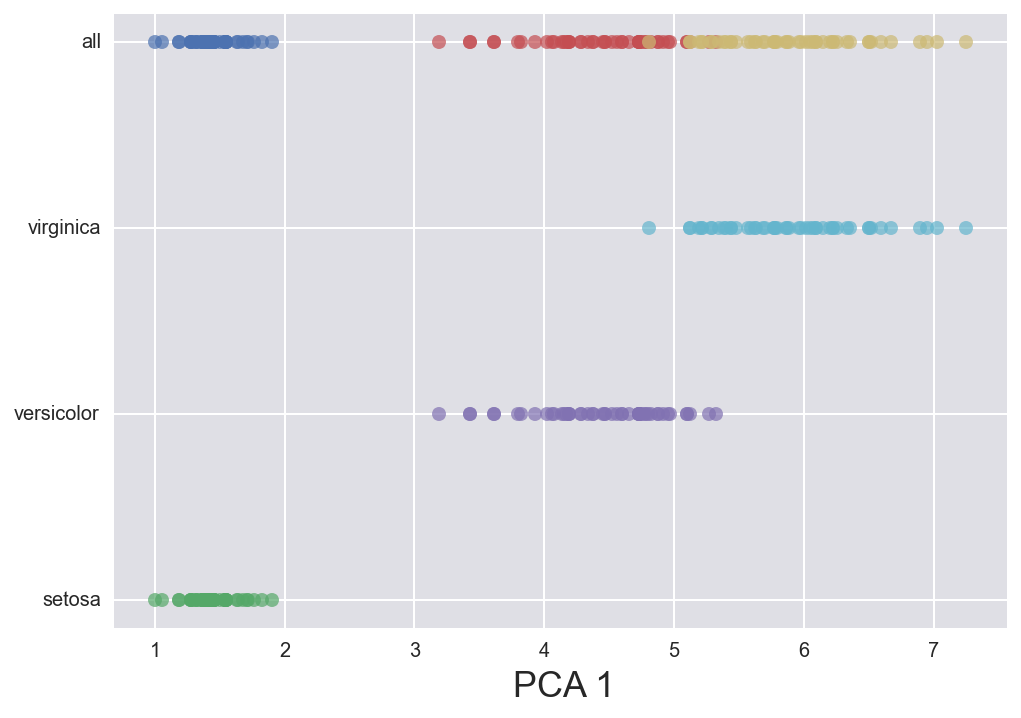

In [21]:
for key, group in df_1D.groupby(['species']):
    plt.plot(group['projection'], np.ones(len(group)) * 3, alpha=0.7,
             label=key, marker='o', linestyle='none')
    group_num = int(np.where(iris.target_names == key)[0])
    plt.plot(group['projection'], np.ones(len(group)) * group_num, alpha=0.7,
             marker='o', linestyle='none')

plt.margins(0.05)
plt.yticks(range(4), np.append(iris.target_names, 'all'))
plt.xlabel('PCA 1')

## Scikit-learn shortcut
Now that we explored step-by-step how to do PCA we can use `scikit-learn` to do it in a single line.  For this we will take the 4 dimensions of the original dataset and explore how much variability is explained by each of the resulting principal components.

As we saw in the [LASSO tutorial](http://bebi103.caltech.edu/2015/protected/tutorials/r4_lasso_ridge.html), `scikit-learn` utilized Python's object orientation.  We first instantiate a `sklearn.decomposition.PCA` object, and the use the `fit()` method to get PCA on our data.  The attributes of the `PCA` instance that end in underscores are the computed values.

In [22]:
# Calculate the principal components using scikit-learn
sklearn_pca = sklearn.decomposition.PCA()
sklearn_pca.fit(df_iris[iris.feature_names])
print('Variance percent explained\n', sklearn_pca.explained_variance_ratio_)

Variance percent explained
 [ 0.92461621  0.05301557  0.01718514  0.00518309]


From this we can see that the first component already captures 92% of the variability in the data!

We can easily project into a 1D, 2D, or 3D space reducing the dimensionality of the data set. As an exercise, let's project it into a 2D space.

In [23]:
# Perform the PCA again retaining only the top 2 components
sklearn_pca = sklearn.decomposition.PCA(n_components=2)
sklearn_pca.fit(df_iris[iris.feature_names])

# Project the data into this 2D space and convert it back to a tidy dataframe
df_2D = pd.DataFrame(sklearn_pca.transform(df_iris[iris.feature_names]),
                     columns=['PCA1', 'PCA2'])
df_2D['species'] = df_iris['species']
df_2D.head()

,PCA1,PCA2,species
0,-2.684207,-0.326607,setosa
1,-2.715391,0.169557,setosa
2,-2.889820,0.137346,setosa
3,-2.746437,0.311124,setosa
4,-2.728593,-0.333925,setosa


Now we can plot our original 4D data into a 2D space that explains ≈ 93% of the variability.

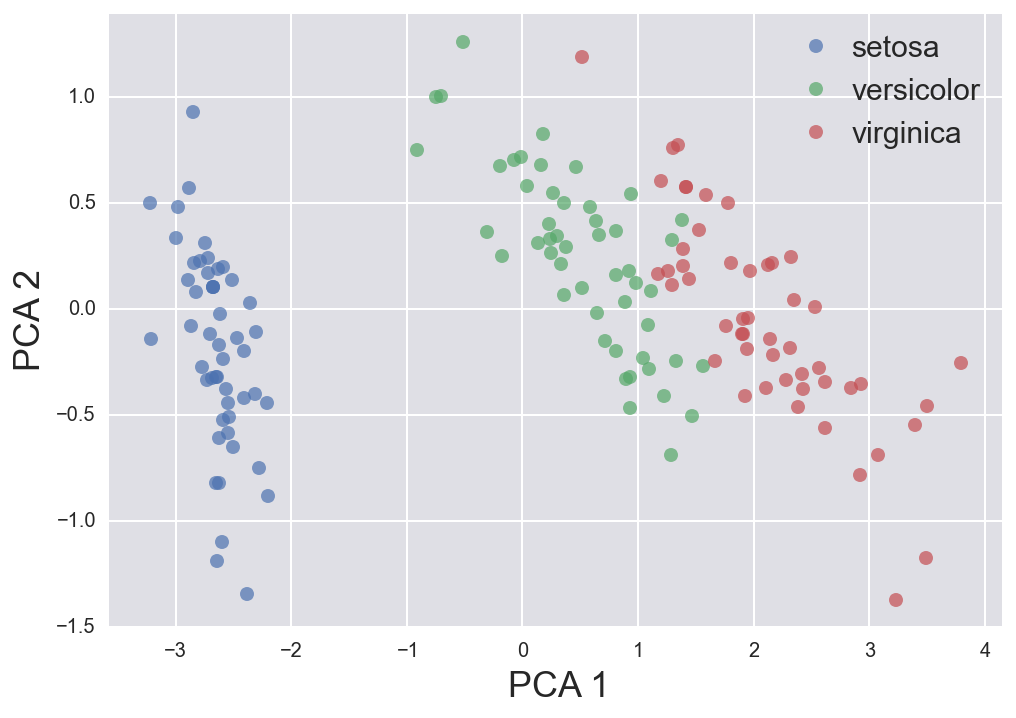

In [24]:
for key, group in df_2D.groupby(['species']):
    plt.plot(group.PCA1, group.PCA2, 'o', alpha=0.7, label=key)

# Tidy up plot
plt.legend(loc=0, fontsize=15)
plt.margins(0.05)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

## Finding the perfect human with PCA

In another [excellent blog entry](https://liorpachter.wordpress.com/2014/12/02/the-perfect-human-is-puerto-rican/), Lior calculates who the perfect human being would be according to their genomic SNP profile.

[SNPedia](http://www.snpedia.com/) is a database that contains a compilation of SNPs classified as *good* or *bad* according to some [GWAS](https://en.wikipedia.org/wiki/Genome-wide_association_study) criteria.
Lior did the following:

1. He created a “*perfect human*” in silico by setting the alleles at all SNPs so that they are “good”.
2. He then added the “*perfect human*” to a panel of genotyped individuals from across a variety of populations and performed **PCA** to reveal the location and population of origin of the individual that was closest to this hypothetical perfect human.

We will use his data and repeat the analysis to find out who the perfect human being is and where is he/she from.  You can download the SNP table, as well as information about the subjects [here](../data/pachter.zip).

We will load it into a `DataFrame` where each column heading refers to a SNP and each row is a given subject.  The index of the row is a string representing the subject (including `'perfect'`), and the column headings are the SNP IDs.

In [25]:
# Read the SNP table
df_snp = pd.read_csv('../data/pachter/geno_table.txt', delimiter='\t',
                     index_col='snp_id').transpose()
df_snp.head()

snp_id,rs307377,rs7366653,rs41307846,rs3753242,rs35082957,rs34154371,rs35426403,rs1143016,rs3890745,rs17472401,...,rs6007897,rs9615362,rs9627183,rs28372448,rs121913039,rs121913037,rs5770917,rs6151429,rs743616,rs2071421
perfect,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
HG00096,2,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
HG00097,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,2,0
HG00099,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
HG00100,2,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0


Because we will do PCA with these data, they should be floating point numbers instead of integers.

In [26]:
df_snp = df_snp.astype(np.float)

We also have data about each individual, such as where they are from.  The `integrated_call_samples_v3.20130502.ALL.panel` file is also include in the [ZIP file](../data/pachter.zip) containing the data.

In [28]:
# Read the description of each individual
fname = '../data/pachter/integrated_call_samples_v3.20130502.ALL.panel'
df_info = pd.read_csv(fname, delimiter='\t', 
                      index_col=0).dropna(axis=1, how='all')
df_info.head()

,pop,super_pop,gender
sample,,,
HG00096,GBR,EUR,male
HG00097,GBR,EUR,female
HG00099,GBR,EUR,female
HG00100,GBR,EUR,female
HG00101,GBR,EUR,male


For convenience, we'll add this information to the SNP `DataFrame`.

In [29]:
# Add to the SNP dataframe the information about gender and super_pop
aux_cols = ['pop', 'super_pop', 'gender']
df_snp[aux_cols] = df_info

# Change the super_pop column for the perfect human being
df_snp.loc['perfect', ['pop', 'super_pop']] = ['Perfect Human']*2

# Take a look at auxiliary columns
df_snp[aux_cols].head()

snp_id,pop,super_pop,gender
perfect,Perfect Human,Perfect Human,NaN
HG00096,GBR,EUR,male
HG00097,GBR,EUR,female
HG00099,GBR,EUR,female
HG00100,GBR,EUR,female


### The PCA subspaces are not scale invariant.
As explained again in Lior's blog (yes I highly recommend you to read this blog) the subspaces that you obtain from performing PCA are not scale invariant. This means that, for example, if your dataset contains things measured in *nanometers* and things measured in *meters*, or even worse things measuring completely unrelated things, the units in which your measurement is stored would affect the PCA analysis.

The simplest way to avoid this issue is to form a "**common set of units**" by standardizing your values such that they all have a common mean and variance (usually set to be zero and one respectively).

Fortunately, as in almost every case, `scikit-learn` can do the job for us. We will simply use the `StandardScaler` class from the `preprocessing` module of `scikit-learn` to fix this.

In [30]:
# Standardize the data before performing PCA
# We use .drop to remove the gender and super_pop columns to avoid errors.
df_snp_std = sklearn.preprocessing.StandardScaler().fit_transform(
                            df_snp.drop(aux_cols, axis=1))

Now that everything is nicely centered at zero with standard deviation one we can perform the PCA in basically one line. The rest of the code is to get a tidy `DataFrame` again.

In [32]:
# Perform the PCA and transform the data
n_components = 5
snp_pca = sklearn.decomposition.PCA(n_components=n_components)

# Project the data into this 2D space
snp_pca.fit(df_snp_std)
df_snp_pca = snp_pca.transform(df_snp_std)

# Convert back to a nice tidy dataframe
df_snp_pca = pd.DataFrame(df_snp_pca, 
                columns=['PCA' + str(x) for x in range(1, n_components+1)], 
                index=df_snp.index)

# Add again the gender, pop, and super_pop columns
df_snp_pca[aux_cols] = df_snp[aux_cols]
df_snp_pca.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,pop,super_pop,gender
perfect,-2.221873,13.823952,-193.950136,26.727418,-2.305852,Perfect Human,Perfect Human,NaN
HG00096,-6.037516,15.947683,-0.535330,-3.398783,-3.554483,GBR,EUR,male
HG00097,-6.310191,14.804931,-1.028922,-13.755716,4.553016,GBR,EUR,female
HG00099,-7.102287,15.820245,-4.378239,-4.123260,-3.089383,GBR,EUR,female
HG00100,-6.006800,17.297061,-0.386986,-4.470884,-2.657263,GBR,EUR,female


Let's plot the first two principal components and find out who the perfect human being is!

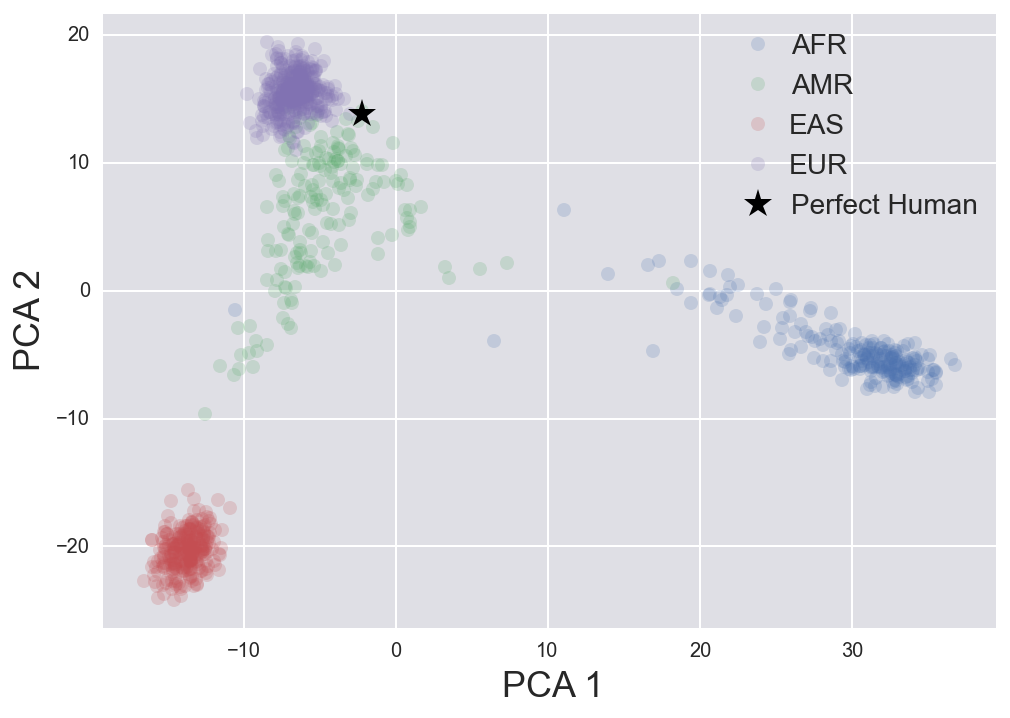

In [37]:
# Plot all populations except the perfect human
df_gb = df_snp_pca[~df_snp_pca['super_pop'].isin(
                   ['Perfect Human'])].groupby(['super_pop'])
for key, group in df_gb:
    plt.plot(group.PCA1, group.PCA2, 'o', alpha=0.2, label=key)

# Add the perefect human being to the plot
plt.plot(df_snp_pca.ix['perfect'].PCA1, df_snp_pca.ix['perfect'].PCA2, '*', 
         markersize=15, color='black', label=df_snp_pca.ix['perfect'].super_pop)

# Tidy the plot.
plt.margins(0.05)
plt.legend(loc=0, fontsize=14)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

Wow. Its kind of hard to find from this plot who is the perfect human being... if only there was a way to plot this in an interactive fashion where we could zoom in the plot and hover over the data to get information.

Oh wait! there is such a thing, we can use `bokeh` to explore the data better.

In [38]:
# What pops up on hover?
tooltips = [('gender', '@gender'),
            ('pop', '@pop'),
            ('ID', '@index')]

# Make the hover tool
hover = bokeh.models.HoverTool(tooltips=tooltips)

# Create figure
p = bokeh.plotting.figure(background_fill='#DFDFE5', plot_width=650, 
                          plot_height=450)
p.xgrid.grid_line_color = 'white'
p.ygrid.grid_line_color = 'white'
p.xaxis.axis_label ='PCA 1'
p.yaxis.axis_label ='PCA 2'

# Add the hover tool
p.add_tools(hover)

# Define colors in a dictionary to access them with
# the key from the pandas groupby funciton.
keys = df_snp_pca.super_pop.dropna().unique()
color_dict = {k: bebi103.rgb_frac_to_hex(sns.color_palette()[i]) 
                      for i, k in enumerate(sorted(keys))}

for key, group in df_snp_pca.groupby('super_pop'):
    # Specify data source
    source = bokeh.models.ColumnDataSource(group)
    
    # Populate glyphs
    if key == 'Perfect Human':
        p.diamond_cross(x='PCA1', y='PCA2', size=20, source=source, 
                        color='black', fill_color=None, line_width=2,
                        legend=key)
    else:
        p.circle(x='PCA1', y='PCA2', size=7, alpha=0.2, source=source,
                 color=color_dict[key], legend=key)

p.legend.background_fill_alpha = 0.25
p.legend.background_fill_color = 'blanchedalmond'
bokeh.io.show(p)

So the closest point to the perfect human being is patient [HG00737](https://catalog.coriell.org/0/Sections/Search/Sample_Detail.aspx?Ref=HG00737&PgId=166) a ***Puerto Rican woman***!

But is this true? Let's see what the 3rd principal component tells us about this.

In [42]:
# Make the hover tool
hover = bokeh.models.HoverTool(tooltips=tooltips)

# Create figure
p = bokeh.plotting.figure(background_fill='#DFDFE5', plot_width=650, 
                          plot_height=450)
p.xgrid.grid_line_color = 'white'
p.ygrid.grid_line_color = 'white'
p.xaxis.axis_label ='PCA 1'
p.yaxis.axis_label ='PCA 3'

# Add the hover tool
p.add_tools(hover)

for key, group in df_snp_pca.groupby('super_pop'):
    # Specify data source
    source = bokeh.models.ColumnDataSource(group)
    
    # Populate glyphs
    if key == 'Perfect Human':
        p.diamond_cross(x='PCA1', y='PCA3', size=20, source=source, 
                        color='black', fill_color=None, line_width=2,
                       legend=key)
    else:
        p.circle(x='PCA1', y='PCA3', size=7, alpha=0.2, source=source,
                 color=color_dict[key], legend=key)

p.legend.background_fill_alpha = 0.25
p.legend.background_fill_color = 'blanchedalmond'
p.legend.orientation = 'bottom_right'
bokeh.io.show(p)

Wow! The perfect human is actually... not human.  What happened here?

It seems that we were fooled by seeing the data only from one angle. Let's put the three top principal components in a single plot.

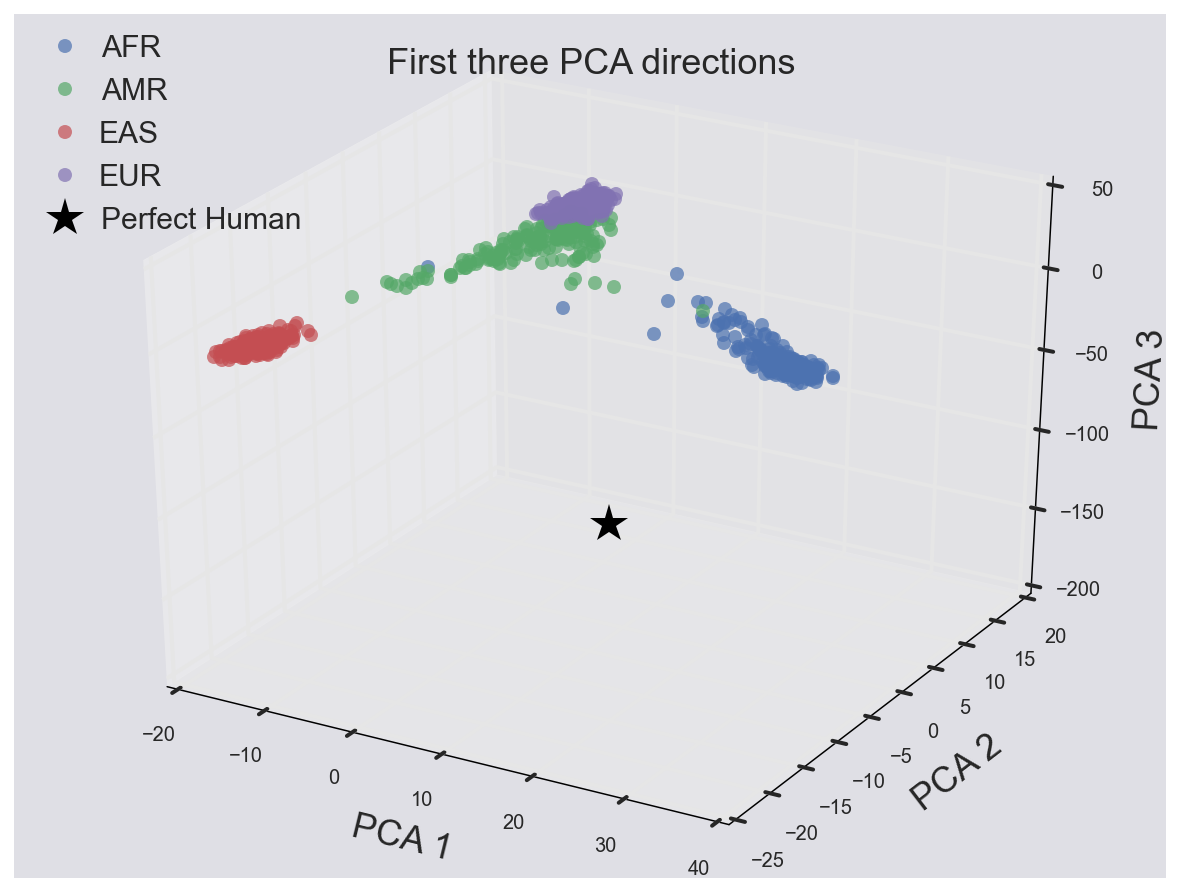

In [40]:
fig = plt.figure(1, figsize=(8, 6))
ax = mpl_toolkits.mplot3d.Axes3D(fig)
for key, group in df_snp_pca.groupby(['super_pop']):
    if key == 'Perfect Human':
        ax.plot(group.PCA1, group.PCA2, group.PCA3, 'k*', markersize=20,
                label=key)
    else:
        ax.plot(group.PCA1, group.PCA2, group.PCA3, 'o', alpha=0.7, label=key)

ax.set_title("First three PCA directions")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.legend(loc='upper left', fontsize=15)

The provocative results from just plotting the first two principal components were completely misunderstood from Lior's original intention of showing James Watson that his racist ideas of having a perfect human being were completely wrong.

This blog generated a lot of controversy to the point that scientists from Puerto Rico that collected the samples [explained the actual results](http://www.oleksyk.com/why-there-cant-be-a-perfect-human-from-puerto-rico-or-anywhere-else/) for the people that only read Lior's title.